### Bootstrap for Parameter Inference

- Nonparametric resampling technique for estimating variances and constructing confidence intervals.
- Works on IID data and parameters dependent on the data distribution $ P $.
- Applicable in both parametric and nonparametric models.

### Process

1. Compute the parameter estimate using the full sample:
   - $ \hat{\theta}_n = g(X_1, X_2, \dots, X_N) $
2. Generate bootstrap samples by resampling with replacement:
   - $ X_1^*, X_2^*, \dots, X_N^* \sim P_n $, where $ P_n $ is the empirical distribution.
3. For each bootstrap sample, compute the parameter estimate:
   - $ \hat{\theta}_n^{*,j} = g(X_1^{*,j}, X_2^{*,j}, \dots, X_N^{*,j}) $, for $ j = 1, \dots, B $
4. Compute the bootstrap variance:
   - $ \hat{\sigma}^2 = \frac{1}{B} \sum_{j=1}^B \left( \hat{\theta}_n^{*,j} - \bar{\theta}^* \right)^2 $, where $ \bar{\theta}^* = \frac{1}{B} \sum_{j=1}^B \hat{\theta}_n^{*,j} $
5. Construct the confidence interval:
   - Find quantiles $ t_{\alpha/2} $ and $ t_{1-\alpha/2} $ from the empirical distribution of $ \sqrt{n} (\hat{\theta}_n^{*,j} - \hat{\theta}_n) $.
   - $ C_n = \left[ \hat{\theta}_n - \frac{t_{1-\alpha/2}}{\sqrt{n}}, \hat{\theta}_n - \frac{t_{\alpha/2}}{\sqrt{n}} \right] $

### Advantages

- Nonparametric inference without strong model assumptions.
- Effective for complex estimators like medians or quantiles.

### Limitations

- Computationally intensive for large $ B $.
- Requires IID data; may not hold for dependent or small samples.

+------------+-------+--------------+-------------------+------------------+----------------+--------------------+--------------------+------------------+----------------------+
| Param      |     B |   True Value |   Full-Sample Est |   Bootstrap Mean |   Bootstrap SE | 95% Bootstrap CI   |   Monte Carlo Mean |   Monte Carlo SE | 95% Monte Carlo CI   |
+============+=======+==============+===================+==================+================+====================+====================+==================+======================+
| Mean       |  1000 |          100 |           99.2563 |          99.2454 |         0.2935 | (98.6895, 99.7973) |           100.004  |           0.3125 | (99.3915, 100.6166)  |
+------------+-------+--------------+-------------------+------------------+----------------+--------------------+--------------------+------------------+----------------------+
| Biased Var |  1000 |           49 |           46.2703 |          46.2533 |         2.9408 | (40.5876, 51.988

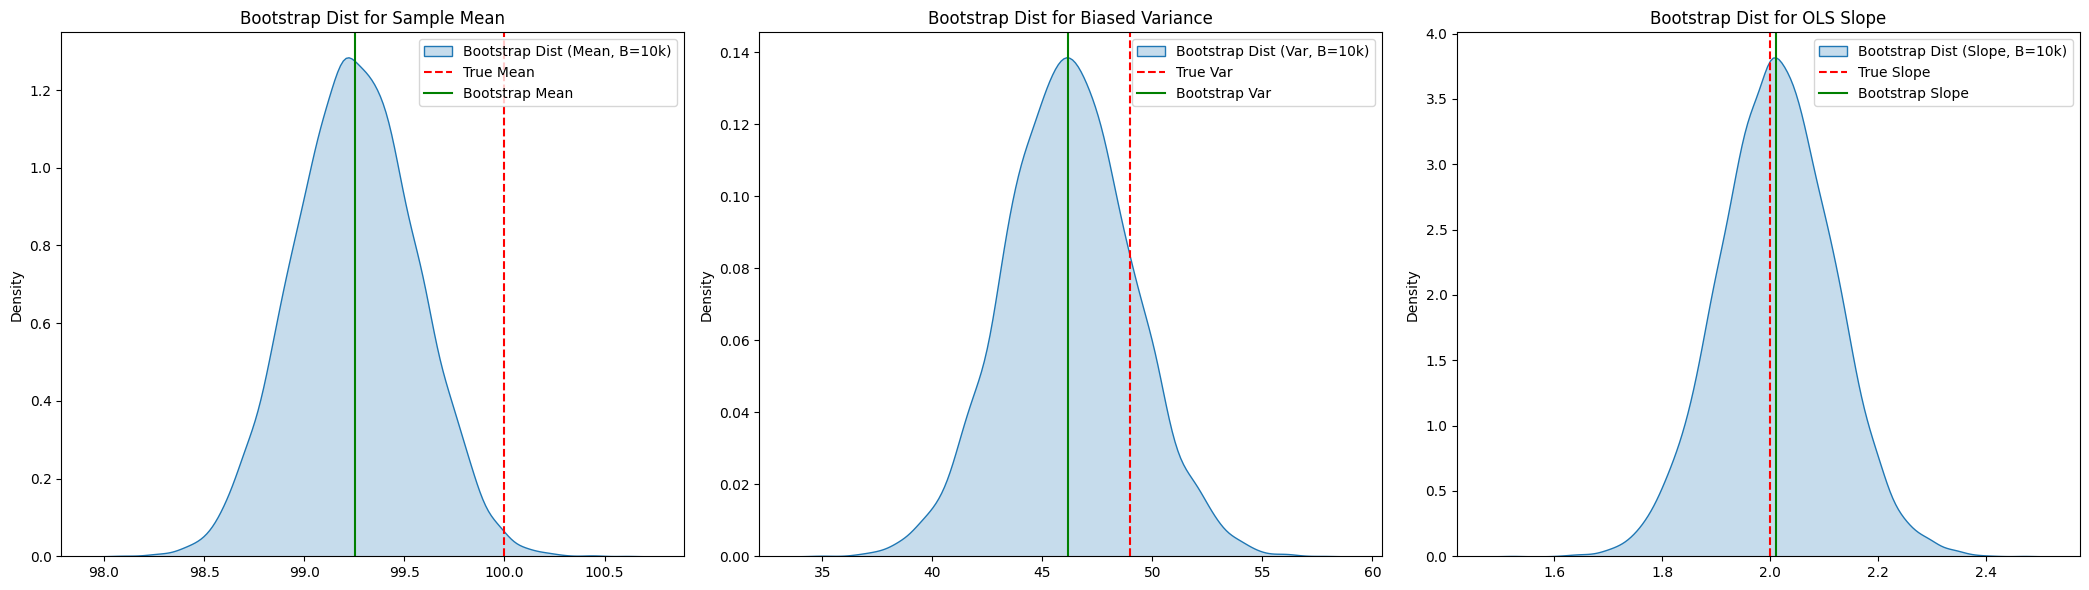

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skewnorm
from tabulate import tabulate

# --- Bootstrap function (Percentile CI) ---
def bootstrap(data, X=None, estimator_func=None, B=1000, alpha=0.05):
    """
    Returns:
      full_sample_estimate,
      boot_estimates (array),
      boot_mean,
      boot_se,
      (ci_lower, ci_upper) via percentile
    """
    N = len(data)
    # Full-sample estimate
    if X is None:
        full_est = estimator_func(data)
    else:
        full_est = estimator_func(data, X)

    # Resample with replacement
    boot_estimates = []
    for _ in range(B):
        idx = np.random.randint(0, N, size=N)
        if X is None:
            sample_data = data[idx]
            boot_estimates.append(estimator_func(sample_data))
        else:
            sample_Y = data[idx]
            sample_X = X[idx]
            boot_estimates.append(estimator_func(sample_Y, sample_X))

    boot_estimates = np.array(boot_estimates)
    boot_mean = np.mean(boot_estimates)
    boot_se = np.std(boot_estimates, ddof=1)
    ci_lower = np.percentile(boot_estimates, 100 * alpha / 2)
    ci_upper = np.percentile(boot_estimates, 100 * (1 - alpha / 2))
    return full_est, boot_estimates, boot_mean, boot_se, (ci_lower, ci_upper)

# --- Example estimators ---
def biased_variance(data):
    return np.sum((data - np.mean(data))**2) / len(data)

def ols_slope(Y, X):
    return np.sum((X - np.mean(X))*(Y - np.mean(Y))) / np.sum((X - np.mean(X))**2)

# ---------------------
# 1) DATA GENERATION
# ---------------------
np.random.seed(42)

# -- Mean & Variance data --
N_meanvar = 500
true_mean = 100
true_std  = 7
true_variance = true_std**2
data = skewnorm.rvs(a=0, loc=true_mean, scale=true_std, size=N_meanvar)

# -- OLS slope data --
n_slope = 100
true_intercept = 5
true_slope_val = 2
true_error_std = 3
X = np.random.uniform(0, 10, size=n_slope)
Y = true_intercept + true_slope_val * X + np.random.normal(0, true_error_std, size=n_slope)

# ---------------------
# 2) MONTE CARLO REF
# ---------------------
num_trials = 10_000

# -- For Mean & Variance --
mc_samples = [skewnorm.rvs(a=0, loc=true_mean, scale=true_std, size=N_meanvar) for _ in range(num_trials)]
mc_means = np.array([np.mean(s) for s in mc_samples])
mc_vars  = np.array([biased_variance(s) for s in mc_samples])

mc_mean_of_means = np.mean(mc_means)
mc_se_of_means   = np.std(mc_means, ddof=1)
mc_ci_means = (
    mc_mean_of_means - 1.96 * mc_se_of_means,
    mc_mean_of_means + 1.96 * mc_se_of_means
)

mc_mean_of_vars = np.mean(mc_vars)
mc_se_of_vars   = np.std(mc_vars, ddof=1)
mc_ci_vars = (
    mc_mean_of_vars - 1.96 * mc_se_of_vars,
    mc_mean_of_vars + 1.96 * mc_se_of_vars
)

# -- For OLS Slope --
mc_slopes = []
for _ in range(num_trials):
    mc_X = np.random.uniform(0, 10, size=n_slope)
    mc_Y = true_intercept + true_slope_val * mc_X + np.random.normal(0, true_error_std, size=n_slope)
    mc_slopes.append(ols_slope(mc_Y, mc_X))
mc_slopes = np.array(mc_slopes)
mc_mean_slope = np.mean(mc_slopes)
mc_se_slope   = np.std(mc_slopes, ddof=1)
mc_ci_slope   = (
    mc_mean_slope - 1.96 * mc_se_slope,
    mc_mean_slope + 1.96 * mc_se_slope
)

# ---------------------
# 3) COMPARE DIFFERENT B
# ---------------------
B_values = [1000, 10000]

results_table = [
    [
        "Param", "B", "True Value",
        "Full-Sample Est", "Bootstrap Mean", "Bootstrap SE", "95% Bootstrap CI",
        "Monte Carlo Mean", "Monte Carlo SE", "95% Monte Carlo CI"
    ]
]

for B in B_values:
    # --- SAMPLE MEAN ---
    mean_full, mean_boot_distr, mean_boot_est, mean_boot_se, mean_boot_ci = \
        bootstrap(data, estimator_func=np.mean, B=B)
    results_table.append([
        "Mean", B, f"{true_mean:.2f}",
        f"{mean_full:.4f}",
        f"{mean_boot_est:.4f}",
        f"{mean_boot_se:.4f}",
        f"({mean_boot_ci[0]:.4f}, {mean_boot_ci[1]:.4f})",
        f"{mc_mean_of_means:.4f}",
        f"{mc_se_of_means:.4f}",
        f"({mc_ci_means[0]:.4f}, {mc_ci_means[1]:.4f})"
    ])

    # --- BIASED VARIANCE ---
    var_full, var_boot_distr, var_boot_est, var_boot_se, var_boot_ci = \
        bootstrap(data, estimator_func=biased_variance, B=B)
    results_table.append([
        "Biased Var", B, f"{true_variance:.2f}",
        f"{var_full:.4f}",
        f"{var_boot_est:.4f}",
        f"{var_boot_se:.4f}",
        f"({var_boot_ci[0]:.4f}, {var_boot_ci[1]:.4f})",
        f"{mc_mean_of_vars:.4f}",
        f"{mc_se_of_vars:.4f}",
        f"({mc_ci_vars[0]:.4f}, {mc_ci_vars[1]:.4f})"
    ])

    # --- OLS SLOPE ---
    slope_full, slope_boot_distr, slope_boot_est, slope_boot_se, slope_boot_ci = \
        bootstrap(Y, X, estimator_func=ols_slope, B=B)
    results_table.append([
        "OLS Slope", B, f"{true_slope_val:.2f}",
        f"{slope_full:.4f}",
        f"{slope_boot_est:.4f}",
        f"{slope_boot_se:.4f}",
        f"({slope_boot_ci[0]:.4f}, {slope_boot_ci[1]:.4f})",
        f"{mc_mean_slope:.4f}",
        f"{mc_se_slope:.4f}",
        f"({mc_ci_slope[0]:.4f}, {mc_ci_slope[1]:.4f})"
    ])

# ---------------------
# 4) PRINT TABLE
# ---------------------
print(tabulate(results_table, headers="firstrow", tablefmt="grid"))

# ---------------------
# 5) OPTIONAL PLOTS
# ---------------------

# For B=10_000, let's visualize distributions
_, mean_boot_distr_10k, mean_boot_est_10k, _, _ = \
    bootstrap(data, estimator_func=np.mean, B=10000)
_, var_boot_distr_10k, var_boot_est_10k, _, _ = \
    bootstrap(data, estimator_func=biased_variance, B=10000)
_, slope_boot_distr_10k, slope_boot_est_10k, _, _ = \
    bootstrap(Y, X, estimator_func=ols_slope, B=10000)

plt.figure(figsize=(21, 6))

# 5a) Mean
plt.subplot(1, 3, 1)
sns.kdeplot(mean_boot_distr_10k, fill=True, label="Bootstrap Dist (Mean, B=10k)")
plt.axvline(true_mean, color="red", linestyle="--", label="True Mean")
plt.axvline(mean_boot_est_10k, color="green", linestyle="-", label="Bootstrap Mean")
plt.title("Bootstrap Dist for Sample Mean")
plt.legend()

# 5b) Biased Variance
plt.subplot(1, 3, 2)
sns.kdeplot(var_boot_distr_10k, fill=True, label="Bootstrap Dist (Var, B=10k)")
plt.axvline(true_variance, color="red", linestyle="--", label="True Var")
plt.axvline(var_boot_est_10k, color="green", linestyle="-", label="Bootstrap Var")
plt.title("Bootstrap Dist for Biased Variance")
plt.legend()

# 5c) OLS Slope
plt.subplot(1, 3, 3)
sns.kdeplot(slope_boot_distr_10k, fill=True, label="Bootstrap Dist (Slope, B=10k)")
plt.axvline(true_slope_val, color="red", linestyle="--", label="True Slope")
plt.axvline(slope_boot_est_10k, color="green", linestyle="-", label="Bootstrap Slope")
plt.title("Bootstrap Dist for OLS Slope")
plt.legend()

plt.tight_layout()
plt.show()


### Polynomial Regression: Confidence Interval for Maximum

- Model: $Y_i = \beta_0 + \beta_1 X_i + \beta_2 X_i^2 + \epsilon_i$, where:
  - $X_i \sim \text{Uniform}(0, 2)$,
  - $\epsilon_i \sim N(0, 0.2^2)$.
- Objective: Estimate $\theta = -\frac{\beta_1}{2\beta_2}$, where $g(X) = \beta_0 + \beta_1 X + \beta_2 X^2$ achieves its maximum.

**Steps**:
1. Estimate $\hat{\beta}_0, \hat{\beta}_1, \hat{\beta}_2$ using least squares.
2. Compute $\hat{\theta} = -\frac{\hat{\beta}_1}{2\hat{\beta}_2}$.
3. Generate $B$ bootstrap samples, fit the model, and compute $\hat{\theta}^*$ for each sample.
4. Construct a confidence interval using the bootstrap distribution of $\hat{\theta}^*$.

### Partial Correlation

- Model: $(X_1, Y_1, Z_1), \dots, (X_n, Y_n, Z_n) \sim P$, where:
  - $Z \sim N(0, 1)$,
  - $X = 10Z + \epsilon$, $Y = 10Z + \eta$,
  - $\epsilon, \eta \sim N(0, 1)$.
- Objective: Estimate partial correlation $\theta = \frac{\Omega_{12}}{\sqrt{\Omega_{11} \Omega_{22}}}$, where $\Omega = \Sigma^{-1}$.

**Steps**:
1. Compute the sample partial correlation from the sample covariance matrix.
2. Generate $B$ bootstrap samples, recompute partial correlations, and create a bootstrap distribution.
3. Construct a confidence interval from the bootstrap distribution.


In [2]:
import numpy as np
from sklearn.linear_model import LinearRegression
from tabulate import tabulate

# -------------------------
# Example 140: Polynomial Max
# -------------------------
def gen_data_poly(n=100, seed=0):
    np.random.seed(seed)
    X = np.random.uniform(0, 2, size=n)
    eps = np.random.normal(0, 0.2, size=n)
    # True params
    beta0, beta1, beta2 = 1.0, 2.0, -1.0
    Y = beta0 + beta1 * X + beta2 * X**2 + eps
    return X, Y

def poly_max_bootstrap(X, Y, B=1000, alpha=0.05):
    # Full-sample fit
    reg = LinearRegression().fit(np.c_[X, X**2], Y)
    b0, b1, b2 = reg.intercept_, *reg.coef_
    theta_full = -b1 / (2 * b2)

    # Bootstrap
    n = len(Y)
    thetas = []
    for _ in range(B):
        idx = np.random.randint(0, n, n)
        XX, YY = X[idx], Y[idx]
        r = LinearRegression().fit(np.c_[XX, XX**2], YY)
        b0_, b1_, b2_ = r.intercept_, *r.coef_
        thetas.append(-b1_ / (2 * b2_))
    thetas = np.array(thetas)
    ci = np.percentile(thetas, [100*alpha/2, 100*(1-alpha/2)])
    return theta_full, thetas.mean(), thetas.std(ddof=1), ci

# -------------------------
# Example 141: Partial Correlation
# -------------------------
def gen_data_partial(n=200, seed=0):
    np.random.seed(seed)
    Z = np.random.normal(0, 1, n)
    X = 10*Z + np.random.normal(0, 1, n)
    Y = 10*Z + np.random.normal(0, 1, n)
    return X, Y, Z

def partial_corr_bootstrap(X, Y, Z, B=1000, alpha=0.05):
    # Compute sample partial corr
    # partial corr(X,Y|Z) = -Sigma^{-1}_{12}/sqrt(...)
    # simpler to regress out Z from X,Y then corr
    def partial_corr(x, y, z):
        # Regress X on Z => X_resid
        bx = np.polyfit(z, x, 1)
        X_resid = x - (bx[0]*z + bx[1])
        # Regress Y on Z => Y_resid
        by = np.polyfit(z, y, 1)
        Y_resid = y - (by[0]*z + by[1])
        return np.corrcoef(X_resid, Y_resid)[0, 1]

    pc_full = partial_corr(X, Y, Z)
    n = len(X)
    pcs = []
    for _ in range(B):
        idx = np.random.randint(0, n, n)
        pcs.append(partial_corr(X[idx], Y[idx], Z[idx]))
    pcs = np.array(pcs)
    ci = np.percentile(pcs, [100*alpha/2, 100*(1-alpha/2)])
    return pc_full, pcs.mean(), pcs.std(ddof=1), ci

# -------------------------
# Run & Display
# -------------------------
X_poly, Y_poly = gen_data_poly()
theta_full, theta_mean, theta_se, theta_ci = poly_max_bootstrap(X_poly, Y_poly)

X_pc, Y_pc, Z_pc = gen_data_partial()
pc_full, pc_mean, pc_se, pc_ci = partial_corr_bootstrap(X_pc, Y_pc, Z_pc)

table = [
    ["Example", "Full-Sample Est.", "Boot Mean", "Boot SE", "95% CI"],
    ["Poly Max (theta)", f"{theta_full:.3f}", f"{theta_mean:.3f}", f"{theta_se:.3f}", f"({theta_ci[0]:.3f}, {theta_ci[1]:.3f})"],
    ["Partial Corr", f"{pc_full:.3f}", f"{pc_mean:.3f}", f"{pc_se:.3f}", f"({pc_ci[0]:.3f}, {pc_ci[1]:.3f})"]
]
print(tabulate(table, headers="firstrow"))

Example             Full-Sample Est.    Boot Mean    Boot SE  95% CI
----------------  ------------------  -----------  ---------  --------------
Poly Max (theta)               0.994        0.994      0.015  (0.965, 1.021)
Partial Corr                   0.184        0.183      0.065  (0.060, 0.314)


### 11.7 The High-Dimensional Bootstrap

Extends bootstrap methodology to high-dimensional data where dimensions \( d \) may exceed observations \( n \).

### Key Concepts

- Observations \( X_1, \dots, X_n \in \mathbb{R}^d \), with \( d \) possibly growing with \( n \) (e.g., \( d = d_n \)).
- Assumes \( X_i \) is sub-Gaussian:
  $$
  \mathbb{E}[e^{t^T X}] \leq e^{c \|t\|^2}, \quad c > 0.
  $$
- Goal: Bootstrap-based confidence set for \( \mu = \mathbb{E}[X_i] \).

### Bootstrap Algorithm

1. Generate bootstrap samples \( X_1^*, \dots, X_n^* \sim P_n \).
2. Compute bootstrap sample mean:
   $$
   \hat{\mu}_n^* = \frac{1}{n} \sum_{i=1}^n X_i^*.
   $$
3. Repeat \( B \) times to get \( \hat{\mu}_n^{*,1}, \dots, \hat{\mu}_n^{*,B} \).
4. Compute bootstrap quantile:
   $$
   \hat{F}_n(t) = \frac{1}{B} \sum_{j=1}^B \mathbb{I}\left(\sqrt{n} \| \hat{\mu}_n^{*,j} - \hat{\mu}_n \|_1 \leq t\right).
   $$
5. Construct confidence set:
   $$
   C_n = \{ a \in \mathbb{R}^d : \| a - \hat{\mu}_n \|_1 \leq \frac{t_\alpha}{\sqrt{n}} \},
   $$
   where \( t_\alpha \) is the \( 1-\alpha \) quantile of \( \hat{F}_n(t) \).

### Result

Theoretical guarantees under conditions:
$$
P(\mu \in C_n) \geq 1 - \alpha - c \frac{\log d}{n^{1/8}}, \quad c > 0.
$$

### Applications

- Confidence sets for high-dimensional parameters:
  - Covariance matrices
  - Sparse regression coefficients

### Example: Confidence Set for Covariance Matrix

- Data: \( X_1, \dots, X_n \in \mathbb{R}^k \).
- Parameter: \( \Sigma = \text{Var}(X) \), a \( k \times k \) matrix.
- Procedure:
  - Vectorize \( \Sigma \) into \( \theta = \text{vec}(\Sigma) \), where \( \theta \in \mathbb{R}^d \), \( d = O(k^2) \).
  - Use bootstrap to construct confidence set for \( \theta \).
- Result:
  $$
  P(L_n \leq \Sigma \leq U_n) \geq 1 - \alpha - c \frac{\log d}{n^{1/8}}.
  $$

In [3]:
import numpy as np

def high_dim_bootstrap_confidence_set(X, B=1000, alpha=0.05):
    """
    Given data matrix X (shape: n x d), constructs a (1 - alpha) confidence set
    for the mean mu = E[X], based on the L1 norm (||·||_1).
    """
    n, d = X.shape
    # 1) Full-sample mean
    mu_hat = X.mean(axis=0)

    # 2) Bootstrap means
    boot_means = []
    for _ in range(B):
        idx = np.random.randint(0, n, size=n)
        X_star = X[idx]
        boot_means.append(X_star.mean(axis=0))
    boot_means = np.array(boot_means)

    # 3) Empirical distribution of sqrt(n)*L1 distances
    dist_l1 = np.sqrt(n) * np.linalg.norm(boot_means - mu_hat, ord=1, axis=1)
    t_alpha = np.percentile(dist_l1, 100*(1-alpha))

    # 4) Confidence set
    # C_n = { a in R^d : ||a - mu_hat||_1 <= t_alpha / sqrt(n) }
    radius = t_alpha / np.sqrt(n)
    return mu_hat, radius

# ------------------------
# Example usage
# ------------------------
if __name__ == "__main__":
    np.random.seed(42)
    n, d = 200, 500
    # Generate sub-Gaussian data: each row is X_i in R^d
    X = np.random.normal(0, 1, size=(n, d))

    mu_hat, radius = high_dim_bootstrap_confidence_set(X, B=500, alpha=0.05)
    print("Estimated mean (first 5 coords):", mu_hat[:5])
    print("Radius (L1 ball):", radius)
    print("Confidence set: { a : ||a - mu_hat||_1 <= %.3f }" % radius)


Estimated mean (first 5 coords): [ 0.10566083  0.06741384  0.02839866  0.10710838 -0.00460632]
Radius (L1 ball): 30.78268887808528
Confidence set: { a : ||a - mu_hat||_1 <= 30.783 }
